# Modelos estatísticos clássicos e diferenciação

## Exponential Smoothing

O Modelo Naive, que calculada a média dos últimos valores, é um modelo muito simples, mas que pode ser melhorado. Analizando o que ele faz:

$$
\hat{Y}(t) = \frac{Y(t-1) + Y(t-2) + \dots + Y(t-n)}{n}
$$

Ele basicamente atribui o mesmo peso para todas as observações passadas. Mas, intuitivamente, faz mais sentido dar mais peso para as observações mais recentes, e menos peso para as observações mais antigas.

O exponential smoothing faz exatamente isso. Ele atribui pesos decrescentes para observações mais antigas. O peso da observação decresce exponencialmente segundo um fator $0 < \alpha < 1$ [@hyndman2018forecasting]:

$$
\hat{Y}(t) = \alpha Y(t-1) + \alpha(1 - \alpha)Y(t-1) + \alpha(1 - \alpha)^2 Y(t-2) + \dots
$$


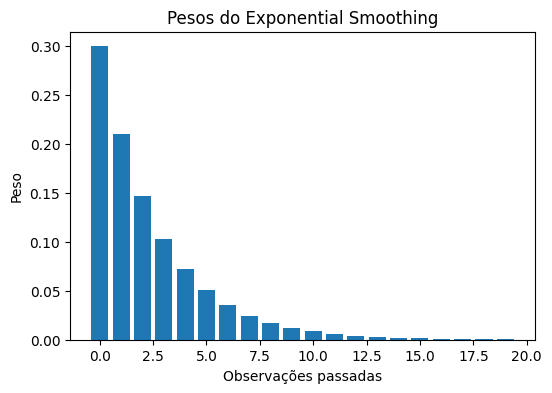

In [1]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
alpha = 0.3
weights = [alpha * (1 - alpha) ** i for i in range(20)]
ax.bar(range(len(weights)), weights)
ax.set_title("Pesos do Exponential Smoothing")
ax.set_xlabel("Observações passadas")
ax.set_ylabel("Peso")
plt.show()

### Usando Exponential Smoothing com sktime

In [2]:
from tsbook.datasets.retail import SyntheticRetail
from sktime.utils.plotting import plot_series

dataset = SyntheticRetail("univariate")
y_train, y_test = dataset.load("y_train", "y_test")

In [3]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(y_train)

ExponentialSmoothing()

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

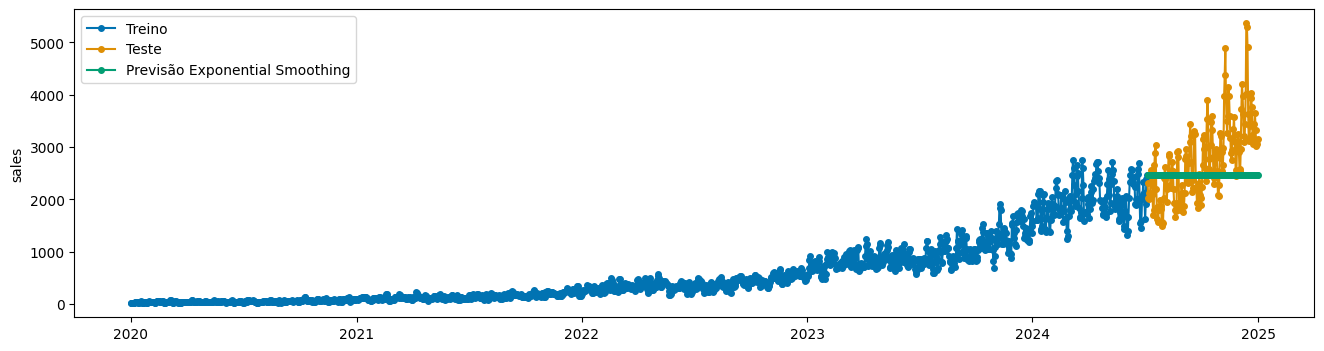

In [4]:
y_pred = model.predict(fh=y_test.index)
plot_series(y_train, y_test, y_pred, labels=["Treino", "Teste", "Previsão Exponential Smoothing"])

Existem versões alternativas que consideram sazonalidade e tendências. Veja a [documentação](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.exp_smoothing.ExponentialSmoothing.html) para mais detalhes.


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

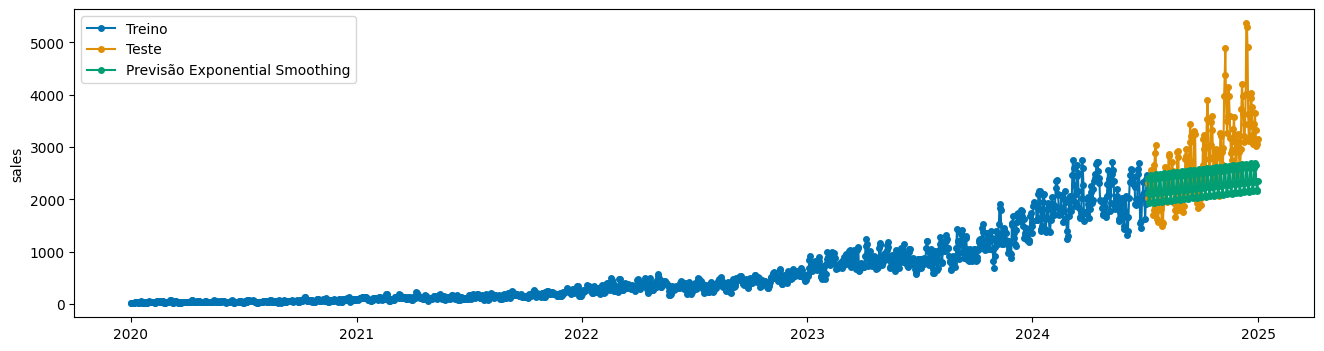

In [5]:
model = ExponentialSmoothing(trend="add", seasonal="add", sp=7)
model.fit(y_train)
y_pred = model.predict(fh=y_test.index)
plot_series(
    y_train,
    y_test,
    y_pred,
    labels=["Treino", "Teste", "Previsão Exponential Smoothing"],
)

## Modelos autoregressivos (AR)

Modelos autoregressivos (AR) são modelos que prevem o valor atual de uma série temporal como uma combinação dos valores passados. O modelo AR(p) usa os últimos p valores para fazer a previsão:

$$
\hat{Y}(t) = \phi_1 Y(t-1) + \phi_2 Y(t-2) + \dots + \phi_p Y(t-p)
$$

onde $\phi_1, \phi_2, \dots, \phi_p$ são os parâmetros do modelo que precisam ser estimados a partir dos dados.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

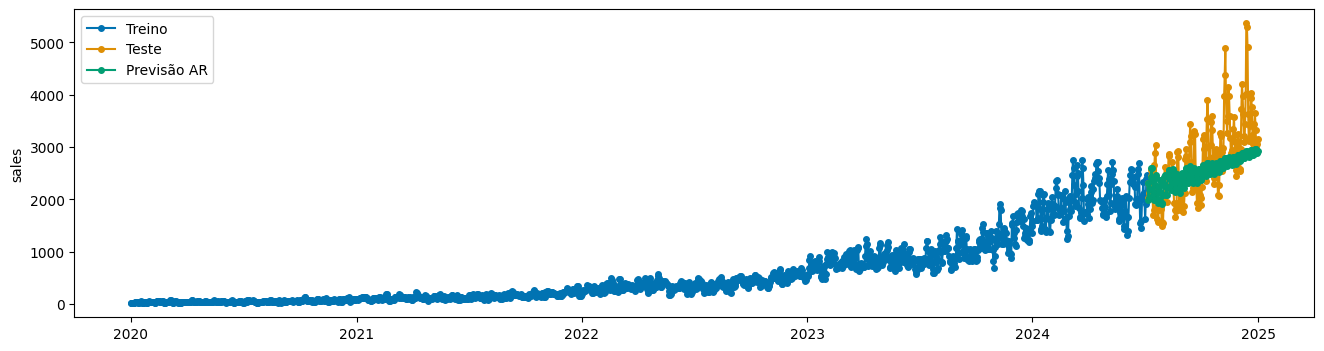

In [6]:
from sktime.forecasting.auto_reg import AutoREG
from sktime.utils.plotting import plot_series

model = AutoREG(lags=31)
model.fit(y_train)

y_pred = model.predict(fh=y_test.index)
plot_series(
    y_train,
    y_test,
    y_pred,
    labels=["Treino", "Teste", "Previsão AR"],
)

Um modelo auto-regressivo mais complexo é o ARIMA, que combina autoregressão (AR), média móvel (MA) e diferenciação integrada (I) para lidar com séries temporais não estacionárias. Não vamos estudar o ARIMA aqui pois envolve conceitos mais avançados, mas temos ele disponível no sktime, `sktime.forecasting.arima.ARIMA`.

## STL: dividir e conquistar

Sabemos que séries temporais podem ser decompostas em componentes de tendência, sazonalidade e resíduos. O modelo STL (Seasonal and Trend decomposition using Loess) é uma técnica que permite fazer essa decomposição de forma robusta.

Temos no sktime o `STLTransformer`, que permite fazer a decomposição STL:

In [7]:
from sktime.transformations.series.detrend import STLTransformer

stl = STLTransformer(sp=365)
stl.fit(y_train)

STLTransformer(sp=365)

E agora podemos inspecionar os componentes:

/var/folders/_2/9y4tsvdd2n3gqjgd2zmlr1km0000gn/T/ipykernel_35866/1542615419.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


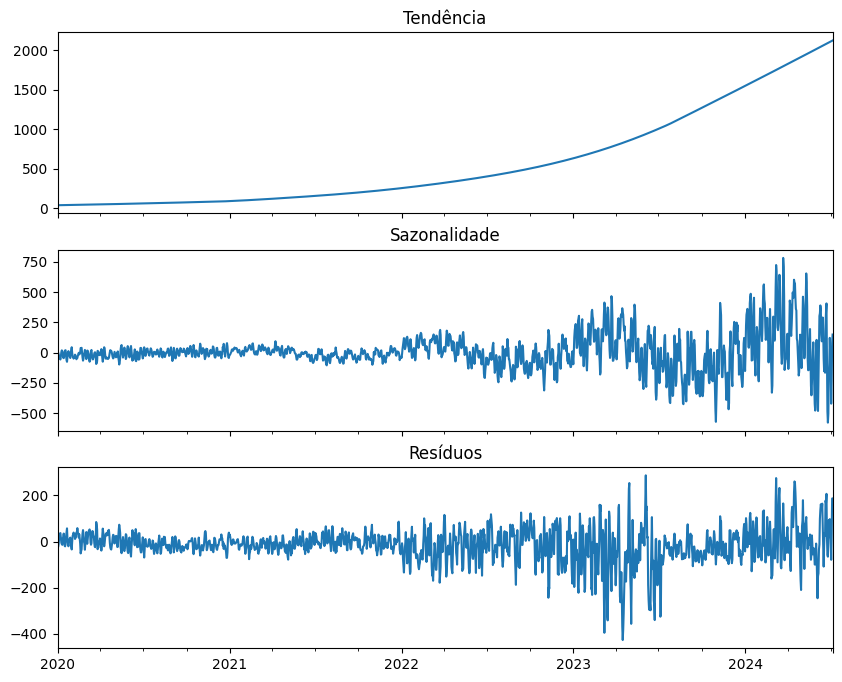

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
stl.trend_.plot.line(ax=ax[0])
ax[0].set_title("Tendência")
stl.seasonal_.plot.line(ax=ax[1])
ax[1].set_title("Sazonalidade")
stl.resid_.plot.line(ax=ax[2])
ax[2].set_title("Resíduos")
fig.show()

Uma possibilidade, uma vez que temos os diferentes componentes, é modelar cada componente separadamente e depois combinar as previsões. O sktime tem o `STLForecaster`, que faz exatamente isso:

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

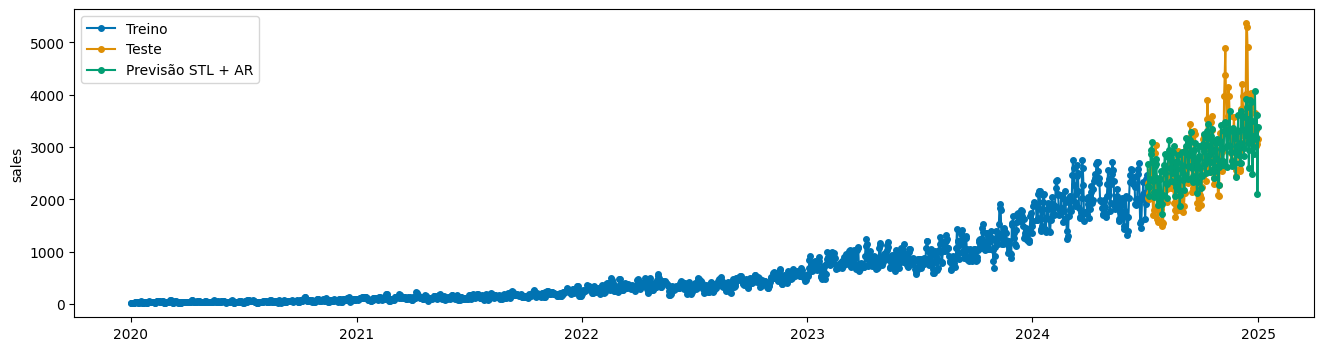

In [9]:
from sktime.forecasting.trend import STLForecaster
from sktime.forecasting.naive import NaiveForecaster

model = STLForecaster(
    forecaster_trend=AutoREG(lags=31),
    forecaster_seasonal=NaiveForecaster(sp=7),
    forecaster_resid=AutoREG(lags=31),
    sp=7,
)

model.fit(y_train)
y_pred = model.predict(fh=y_test.index)

plot_series(
    y_train,
    y_test,
    y_pred,
    labels=["Treino", "Teste", "Previsão STL + AR"],
)

Para fins de demonstração, podemos complicar um pouco mais o modelo, modelando os resíduos com outro `STLForecaster`:

In [10]:
model = STLForecaster(
    forecaster_trend=AutoREG(lags=31),
    forecaster_seasonal=NaiveForecaster(sp=7),
    forecaster_resid=STLForecaster(
        forecaster_trend=AutoREG(lags=31),
        forecaster_seasonal=NaiveForecaster(sp=365),
        forecaster_resid=AutoREG(lags=31),
        sp=365,
    ),
    sp=7,
)

model.fit(y_train)

STLForecaster(forecaster_resid=STLForecaster(forecaster_resid=AutoREG(lags=31),
                                             forecaster_seasonal=NaiveForecaster(sp=365),
                                             forecaster_trend=AutoREG(lags=31),
                                             sp=365),
              forecaster_seasonal=NaiveForecaster(sp=7),
              forecaster_trend=AutoREG(lags=31), sp=7)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

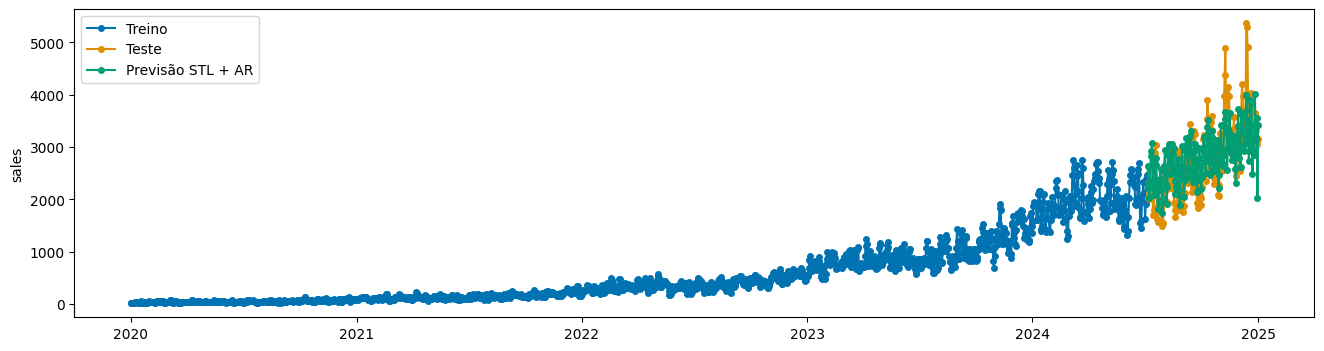

In [11]:
y_pred = model.predict(fh=y_test.index)

plot_series(
    y_train,
    y_test,
    y_pred,
    labels=["Treino", "Teste", "Previsão STL + AR"],
)